# 브루클린 판매 데이터 분석 예제 [01] -- 신규고객 분석

**분석주제 :**
- 전체 고객 중 신규고객의 특성에 어떤 특징이 있는가를 파악

**분석방식 :**
- 데이터 전체, 전체 고객의 개략적 패턴을 분석한 후 신규고객을 구분
- 신규고객만이 가지는 특성을 프로파일링
- 동일 항목을 신규고객이 아닌 기존고객에 대해서도 산출하여 두 집단을 비교

In [1]:
# 공통 라이브러리 지정 및 환경설정

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy.polynomial.polynomial import polyfit

# define random jitter
def rjitt(arr):
    stdev = .01*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

# custom min max scaler
def mnmx_scl(vec):
    vec = (vec-vec.min())/(vec.max()-vec.min())
    return(vec)

# custom zrmx_scler
def zrmx_scl(vec):
    vec = vec/vec.max()
    return(vec)


# matplotlib 에서 한글을 표시하기 위한 설정
import matplotlib.font_manager

font_name = matplotlib.font_manager.FontProperties(
                fname="c:/Windows/Fonts/malgun.ttf"  # 윈도우즈의 한글 폰트 위치를 지정
            ).get_name()
matplotlib.rc('font', family=font_name)

matplotlib.rcParams['axes.unicode_minus'] = False #  음수를 나타내는 '-' 부호가 정상 표시되도록


# local data path
dataPath = 'D:/YONG/myPydata/' # 데이터 위치는 사용자 지정



### 데이터 불러오기

In [2]:
# 판매데이터 불러오기
sales = pd.read_csv(dataPath + 'brk_salesmast01.csv', encoding='euc-kr')
sales = sales.drop(sales.columns[0], axis=1)

#고객데이터 불러오기
custmast = pd.read_csv(dataPath + 'brk_custmast01.csv', encoding='euc-kr')
custmast = custmast.drop(custmast.columns[0], axis=1)

# 상품데이터 불러오기
itemmast = pd.read_csv(dataPath + 'brk_itemmast01.csv', encoding='euc-kr')
itemmast = itemmast.drop(itemmast.columns[0], axis=1)

custmast.head(2)
#itemmast.head(2)

,cust_id,sex,area,birthyr,hh_income,age,marital,ranseq,signup_date
0,B100047771,F,inchon,1997,43000,24,미혼,0,2018-02-17 11:11:27.243860
1,B100060077,F,seoul,1996,26000,25,미혼,1,2018-05-14 11:11:27.243860


## 신규고객 정의하기

In [3]:
# 고객별 가입일자 분포 확인

# 회원가입일자 컬럼 확인
custmast.signup_date

0        2018-02-17 11:11:27.243860
1        2018-05-14 11:11:27.243860
2        2016-09-30 11:11:27.243860
3        2016-05-30 11:11:27.243860
4        2017-04-08 11:11:27.243860
                    ...            
25995    2018-04-06 11:11:27.243860
25996    2019-11-03 11:11:27.243860
25997    2017-03-30 11:11:27.243860
25998    2016-06-11 11:11:27.243860
25999    2016-05-18 11:11:27.243860
Name: signup_date, Length: 26000, dtype: object

- 데이터셋은 2020년 까지의 데이터를 포함
- 데이터셋 기준 현재 시점은 2021년 1월 1일

In [4]:
custmast.signup_date.dtype

dtype('O')

In [5]:
# 가입일자의 데이터 타입은 Object 문자열

In [6]:
# 시간 까지는 필요없고 날짜(day)만 필요

# 날짜까지를 나타내는 10개 자리 추출
custmast.signup_date.str.slice(0,10)

0        2018-02-17
1        2018-05-14
2        2016-09-30
3        2016-05-30
4        2017-04-08
            ...    
25995    2018-04-06
25996    2019-11-03
25997    2017-03-30
25998    2016-06-11
25999    2016-05-18
Name: signup_date, Length: 26000, dtype: object

In [7]:
# 필요한 컬럼들만 복제 -- 고객번호와 회원가입일시
custSignup = custmast[['cust_id', 'signup_date']].copy()

# 날짜 까지만 추출해서 새로운 컬럼으로 추가
custSignup['signupDate'] = custmast.signup_date.str.slice(0,10)

# 일자별 가입 고객수 집계
custSignupAgg = custSignup[['cust_id','signupDate']].groupby('signupDate').count().reset_index() 

custSignupAgg

,signupDate,cust_id
0,2016-01-03,10
1,2016-01-04,17
2,2016-01-05,12
3,2016-01-06,13
4,2016-01-07,13
...,...,...
1811,2020-12-26,3
1812,2020-12-27,3
1813,2020-12-28,2
1814,2020-12-29,1


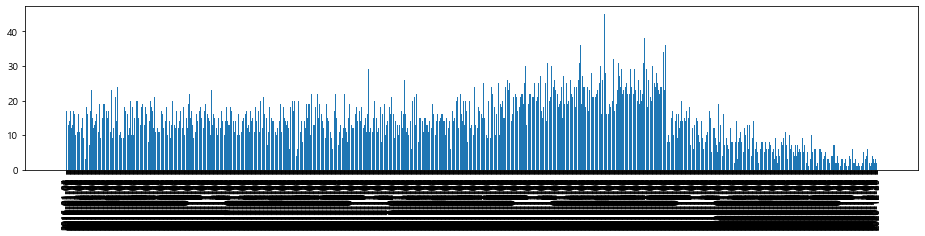

In [8]:
# 일자별 가입회원수 분포 확인

# 일자의 수가 많으므로 가로가 긴 형태로 출력
plt.figure(figsize=(16,3))
# 막대챠트 사용
plt.bar(custSignupAgg.signupDate, custSignupAgg.cust_id)
plt.xticks(rotation=90)
plt.show()

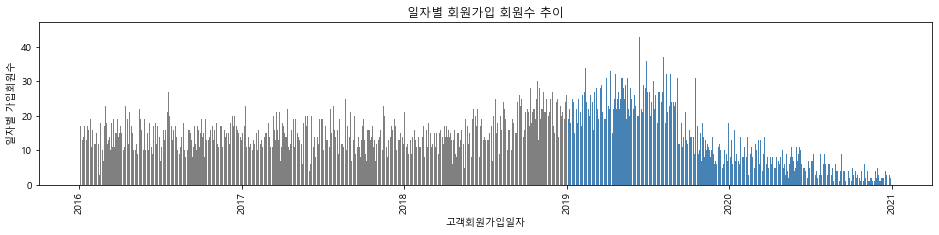

In [9]:
# datetime 형식으로 날짜 값을 변경
dateTexts = pd.to_datetime(custSignupAgg.signupDate, format='%Y-%m-%d')

# 2019년 이후 즉, 데이터셋 기간 이후인 기간 구분하는 색상 지정
colors1 = np.where(custSignupAgg.signupDate>='2019-01-01 00:00:00.0000', 'steelblue', 'grey')

plt.figure(figsize=(16,3))
# 막대챠트의 X축을 날짜 형식으로 표시
plt.bar(dateTexts, custSignupAgg.cust_id,
       color=colors1)
plt.xticks(rotation=90)
plt.xlabel('고객회원가입일자')
plt.ylabel('일자별 가입회원수')
plt.title('일자별 회원가입 회원수 추이')
plt.show()

- 2019년 초반 회원가입이 많이 증가했으나 2019년 후반 감소. 2020년 회원가입은 매우 적었고 감소 패턴이었음
- 2019년 이전에 가입한 회원이 다수 존재함

In [10]:
# 판매내역으로부터 고객별 최초 구매일자 분포 확인

In [11]:
# 판매내역에서 판매일자 컬럼 확인

sales[['cust_id', 'date']].tail()

,cust_id,date
41931,B100044469,2020-10-01 15:19:12.205728
41932,B100044469,2020-10-01 15:19:12.205728
41933,B100044222,2020-10-01 16:22:21.065439
41934,B100013999,2020-12-30 17:14:00.524636
41935,B100025084,2020-11-30 11:37:36.875571


In [12]:
# 판매내역의 판매일자 최솟값과 최댓값 확인
sales.date.min(), sales.date.max()

('2019-01-01 08:29:29.039055', '2020-12-30 22:40:11.831680')

In [13]:
# 고객별 최초 구매일자 파악

# 날짜 중 가장 작은 값이 최초 구매일자
dfcust1stSaledate = sales[['cust_id', 'date']].groupby('cust_id').min().reset_index()
dfcust1stSaledate.tail()

,cust_id,date
15560,B100099964,2019-02-10 19:27:30.820349
15561,B100099970,2019-10-26 14:53:56.313021
15562,B100099976,2020-11-02 19:06:31.587138
15563,B100099981,2020-09-26 22:30:32.905320
15564,B100099990,2019-04-12 12:46:35.024161


In [14]:
# 집계한 테이블에 고객번호가 없는 경우가 있는가 확인

dfcust1stSaledate.cust_id.isna().sum()

0

In [15]:
# 날짜 까지만 추출해서 새로운 컬럼으로 추가
dfcust1stSaledate['minDate'] = dfcust1stSaledate.date.str.slice(0,10)

# 일자별 해당일자 최초 (2년중) 고객수 집계
cust1stSaleAgg = dfcust1stSaledate[['cust_id','minDate']].groupby('minDate').count().reset_index() 

cust1stSaleAgg

,minDate,cust_id
0,2019-01-01,16
1,2019-01-02,21
2,2019-01-03,19
3,2019-01-04,21
4,2019-01-05,31
...,...,...
725,2020-12-26,24
726,2020-12-27,42
727,2020-12-28,13
728,2020-12-29,11


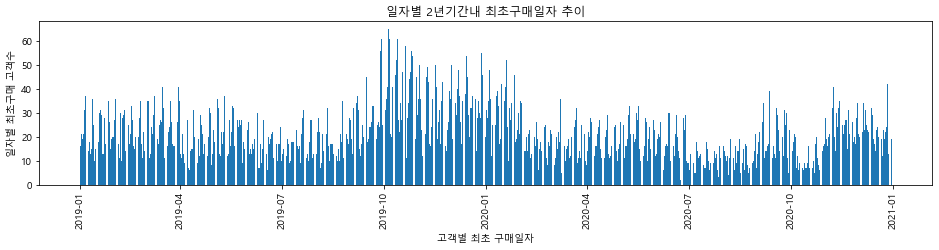

In [16]:
# datetime 형식으로 날짜 값을 변경
dateTexts = pd.to_datetime(cust1stSaleAgg.minDate, format='%Y-%m-%d')

plt.figure(figsize=(16,3))

# 막대챠트의 X축을 날짜 형식으로 표시
plt.bar(dateTexts, cust1stSaleAgg.cust_id)
plt.xticks(rotation=90)
plt.xlabel('고객별 최초 구매일자')
plt.ylabel('일자별 최초구매 고객수')
plt.title('일자별 2년기간내 최초구매일자 추이')
plt.show()

- 2019~2020 기간 중에서 고객별로 가장 빠른 구매일자는 2019 10월 ~2020 2월 사이에 집중

In [17]:
#신규고객 기준 설정

# 대안 1 : 회원가입 후 3개월 이내면 신규고객

# 대안 2 : 최초 구매 후 3개월 이내면 신규고객


In [18]:
# 대안 1 : 회원가입 후 3개월

# 최근 3개월 이내에 가입한 회원수와 2년내 구매가 있었던 전체 고객수
custSignupAgg[custSignupAgg.signupDate>='2020-10-01'].cust_id.sum(), len(sales.cust_id.unique())

(224, 15566)

In [19]:
round(224/ 15566*100,2) # 신규회원이 차지하는 비율 pcnt

1.44

In [20]:
# 대안 2 : 최초 구매 후 3개월

cust1stSaleAgg[cust1stSaleAgg.minDate>='2020-10-01'].cust_id.sum()

1762

In [21]:
round(1762/ 15566*100,2) # 신규고객이 차지하는 비율 pcnt

11.32

In [22]:
# 최초구매 여부를 정확하게 파악하기 위해서는 2년보다 긴 전체 판매내역 기간 필요
# 3년 또는 4년전에 구매한 적 있는 고객을 신규고객으로 보기 어렵기 때문

# 결정: 대안 1. 최근 3개월 기준을 적용

## 신규고객 특성 프로파일링

In [23]:
# 신규고객여부를 표시하는 컬럼 추가

# 10, 11, 12월 3개월 안에 가입일자가 있으면 신규회원으로 표시
custSignup['newCustFlg'] = np.where(custSignup.signupDate >='2020-10-01', 'Y','N')

custSignup.sort_values('signupDate').tail(10)

,cust_id,signup_date,signupDate,newCustFlg
24498,B100094438,2020-12-26 11:11:27.243860,2020-12-26,Y
2995,B100018472,2020-12-26 11:11:27.243860,2020-12-26,Y
1482,B100045348,2020-12-26 11:11:27.243860,2020-12-26,Y
16041,B100008906,2020-12-27 11:11:27.243860,2020-12-27,Y
17222,B100090766,2020-12-27 11:11:27.243860,2020-12-27,Y
1258,B100003126,2020-12-27 11:11:27.243860,2020-12-27,Y
12588,B100026909,2020-12-28 11:11:27.243860,2020-12-28,Y
1676,B100005478,2020-12-28 11:11:27.243860,2020-12-28,Y
3991,B100000965,2020-12-29 11:11:27.243860,2020-12-29,Y
4688,B100020922,2020-12-30 11:11:27.243860,2020-12-30,Y


In [24]:
# 신규고객 리스트를 별도 테이블로 추출

newCusts = custSignup[custSignup.newCustFlg=='Y']
newCusts

,cust_id,signup_date,signupDate,newCustFlg
146,B100051939,2020-10-25 11:11:27.243860,2020-10-25,Y
497,B100061014,2020-10-23 11:11:27.243860,2020-10-23,Y
738,B100028114,2020-12-05 11:11:27.243860,2020-12-05,Y
745,B100056080,2020-11-12 11:11:27.243860,2020-11-12,Y
1086,B100098165,2020-10-20 11:11:27.243860,2020-10-20,Y
...,...,...,...,...
25311,B100062391,2020-11-04 11:11:27.243860,2020-11-04,Y
25538,B100025356,2020-12-05 11:11:27.243860,2020-12-05,Y
25679,B100054098,2020-12-10 11:11:27.243860,2020-12-10,Y
25924,B100019548,2020-10-26 11:11:27.243860,2020-10-26,Y


#### 신규고객 집단의 지리인구통계 즉 성별, 연령, 지역적 특성을 집계

In [25]:
# 신규고객 집단의 지리인구통계 즉 성별, 연령, 지역적 특성을 집계

custmast[custmast.cust_id.isin(newCusts.cust_id)]

,cust_id,sex,area,birthyr,hh_income,age,marital,ranseq,signup_date
146,B100051939,F,gangwon,1994,53000,27,기혼,146,2020-10-25 11:11:27.243860
497,B100061014,F,gyunggi,1992,58000,29,기혼,497,2020-10-23 11:11:27.243860
738,B100028114,M,seoul,1989,53000,32,미혼,738,2020-12-05 11:11:27.243860
745,B100056080,F,gangwon,1975,63000,46,기혼,745,2020-11-12 11:11:27.243860
1086,B100098165,M,inchon,1992,50000,29,미혼,1086,2020-10-20 11:11:27.243860
...,...,...,...,...,...,...,...,...,...
25311,B100062391,M,gyunggi,1989,20000,32,미혼,25311,2020-11-04 11:11:27.243860
25538,B100025356,F,inchon,1982,51000,39,기혼,25538,2020-12-05 11:11:27.243860
25679,B100054098,M,seoul,1981,88000,40,기혼,25679,2020-12-10 11:11:27.243860
25924,B100019548,F,inchon,1994,51000,27,미혼,25924,2020-10-26 11:11:27.243860


<AxesSubplot:>

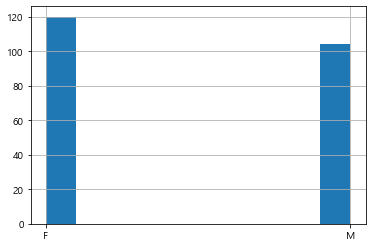

In [26]:
custmast[custmast.cust_id.isin(newCusts.cust_id)].sex.hist()

<AxesSubplot:>

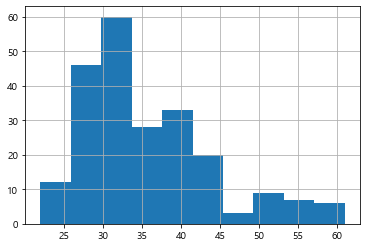

In [27]:
custmast[custmast.cust_id.isin(newCusts.cust_id)].age.hist()

<AxesSubplot:>

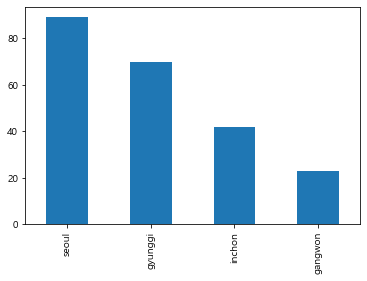

In [28]:
custmast[custmast.cust_id.isin(newCusts.cust_id)].area.value_counts().plot(kind='bar')

#### 신규고객 집단의 구매행동 특성 집계. 즉 구매액, 구매건수, 구매 상품군 특성을 집계

In [29]:
# 신규고객 각자의 구매액 집계

# 판매내역에서 신규고객 해당하는 건만 추출
# 집계에 필요한 고객번호와 금액만 추출
salesNewcust = sales[sales.cust_id.isin(newCusts.cust_id)][['cust_id', 'amt']]

# 고객별 금액 합계 집계
salesNewcust1 = salesNewcust.groupby('cust_id').sum().reset_index()
salesNewcust1.tail()

,cust_id,amt
36,B100083467,70000
37,B100084617,300000
38,B100085903,170000
39,B100090766,180000
40,B100094438,60000


In [30]:
# 구매금액이 있는 신규고객의 수는?

# unique 명령으로 중복된 값 제거 후 len으로 갯수 계산
len(salesNewcust.cust_id.unique())

41

- 224명의 신규고객 (최근 3개월이내에 회원가입한 고객) 중에 구매가 있었던 고객은 41명 뿐
- 그렇다면 나머지는?
- 회원가입만 했을 뿐 구매가 없는 고객 (=**허수 고객**?)

- 회원과 고객으로 개념을 구분하는 것이 필요하지 않은가 검토 필요
- 예를들면 :
- **회원**은 회원가입한 모든 사람
- **고객**은 회원가입했으며 구매한 적이 있는 사람

In [31]:
# 구매없는 신규고객을 포함해서 금액 분포 파악

salesNewcusts2 = newCusts[['cust_id']].merge(salesNewcust1, how='left', on='cust_id')
# 대다수가 금액이 없으므로 0 값으로 채우기
salesNewcusts2.fillna(0, inplace=True)

display(salesNewcusts2.sample(5))

,cust_id,amt
155,B100078973,0.0
200,B100004945,0.0
41,B100085903,170000.0
208,B100013240,140000.0
49,B100052290,0.0


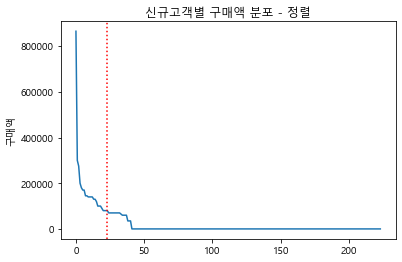

In [32]:
# 신규고객별 구매액 분포 확인

# 금액을 정렬한 후 plot  생성
plt.plot(-np.sort(-salesNewcusts2.amt))
plt.ylabel('구매액')
plt.title('신규고객별 구매액 분포 - 정렬')
# 고객수 10% 지점에 참조선 추가
plt.axvline(len(salesNewcusts2)/10, 
            # 구별 편의를 위해 색상 변경, 점선으로 표시
            color='red', linestyle=":")
plt.show()

- 금액에 따른 정렬을 위해 np.sort 사용
- default는 오름차순 (ascending) 이므로 반대로 정렬하기 위해 음수값으로 바꿔서 정렬한 후 다시 음수를 취해 원래 값으로 변경하는 방법 사용

In [33]:
# 신규고객 각자의 구매건수 집계

# 판매내역에서 신규고객 해당하는 건만 추출
# 집계에 필요한 고객번호와 금액만 추출
salesNewcust = sales[sales.cust_id.isin(newCusts.cust_id)][['cust_id', 'amt']]

# 고객별 구매건수 집계
salesNewcustF1 = salesNewcust.groupby('cust_id').count().reset_index()
salesNewcustF1.columns = ['cust_id','cntSale']
salesNewcustF1.sample(5)

,cust_id,cntSale
14,B100025356,1
27,B100064746,2
0,B100002393,1
4,B100010424,2
18,B100042432,1


- 구매건수가 같은 날 같은 영수증 내의 것일 가능성이 있으므로
- 구매건수나 구매영수증수 등 보다는 구매일수가 분석에 유용할 수 있을 것

In [34]:
# 신규고객 각자의 구매일수 집계

# 판매내역에서 신규고객 해당하는 건만 추출
# 집계에 필요한 고객번호와 일자를 추출
# 고객번호와 날짜가 중복된 건은 필요없으므로 drop_duplicates() 로 제거
salesNewcustF = sales[sales.cust_id.isin(newCusts.cust_id)][['cust_id', 'date']].drop_duplicates()
# 추출 결과 확인
display(salesNewcustF.tail(5))


,cust_id,date
36551,B100051823,2020-12-18 15:33:43.355967
36849,B100064746,2020-12-25 15:35:47.794938
36987,B100042432,2020-12-28 17:43:50.199326
39800,B100016174,2020-11-08 07:52:20.683038
41024,B100017495,2020-12-10 11:13:26.776504


In [35]:
# date 컬럼에서 시간 관련 정보는 필요없는 상황이므로
# 일자만 남기는 형식으로 변경

salesNewcustF['date'] = salesNewcustF.date.str.slice(0,10)
# 추출 결과 확인
display(salesNewcustF.tail(5))

# 날짜가 동일한 중복건 제거
salesNewcustF = salesNewcustF.drop_duplicates()

# 고객별 구매일수 집계
salesNewcustF1 = salesNewcustF.groupby('cust_id').count().reset_index()
salesNewcustF1.columns = ['cust_id','cntSaleday']
salesNewcustF1.sample(5)

,cust_id,date
36551,B100051823,2020-12-18
36849,B100064746,2020-12-25
36987,B100042432,2020-12-28
39800,B100016174,2020-11-08
41024,B100017495,2020-12-10


,cust_id,cntSaleday
39,B100090766,1
33,B100080699,1
3,B100009399,1
22,B100051647,1
37,B100084617,2


In [36]:
# 구매없는 신규고객을 포함해서 구매일수 분포 파악

salesNewcustsF2 = newCusts[['cust_id']].merge(salesNewcustF1, how='left', on='cust_id')
# 대다수가 금액이 없으므로 0 값으로 채우기
salesNewcustsF2.fillna(0, inplace=True)

display(salesNewcustsF2.sample(5))

,cust_id,cntSaleday
216,B100088794,0.0
127,B100080771,0.0
141,B100097027,0.0
149,B100064746,2.0
27,B100022633,1.0


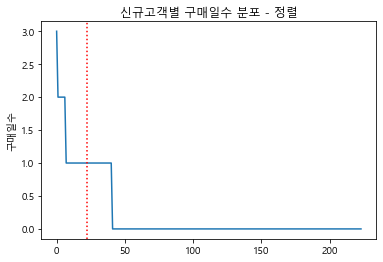

In [37]:
# 신규고객별 구매일수 분포 확인

# 금액을 정렬한 후 plot  생성
plt.plot(-np.sort(-salesNewcustsF2.cntSaleday))
plt.ylabel('구매일수')
plt.title('신규고객별 구매일수 분포 - 정렬')
# 고객수 10% 지점에 참조선 추가
plt.axvline(len(salesNewcustsF2)/10, 
            # 구별 편의를 위해 색상 변경, 점선으로 표시
            color='red', linestyle=":")
plt.show()

- 다수의 신규고객이 구매하지 않았지만 구매한 경우에도 구매가 하루인 경우가 대다수
- 3일이 최대이고, 2~3일 비중 크지 않음

In [38]:
# 구매상품군 집계

# 고객별 상품군별 구매여부 집계 필요
# 구매여부 이므로 동일 고객이 동일 품목을 여러 번 구매한 것은 한 번으로 간주 필요

salesNewcust = sales[sales.cust_id.isin(newCusts.cust_id)][['cust_id', 'scat']]
# 중복제거
salesNewcust = salesNewcust.drop_duplicates()
# 구매여부를 flag로 추가 -- 집계결과를 담을 컬럼
salesNewcust['saleFlg'] = 1

# 고객별 소분류별 구매여부 집계
salesNewcust1 = salesNewcust.groupby(['cust_id','scat']).count().reset_index()
salesNewcust1.tail()

,cust_id,scat,saleFlg
41,B100084617,바지,1
42,B100084617,셔츠,1
43,B100085903,바지,1
44,B100090766,치마,1
45,B100094438,치마,1


<AxesSubplot:>

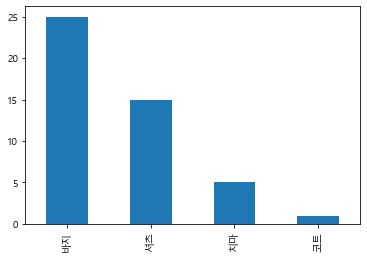

In [39]:
salesNewcust1.scat.value_counts().plot(kind='bar')

### 신규고객 프로파일 요약 테이블 생성

In [40]:
newCusts1 = custmast[custmast.cust_id.isin(newCusts.cust_id)]

# 성비 집계
genderStat = newCusts1.sex.value_counts().head(1) / len(newCusts1) * 100
genderStat

F    53.571429
Name: sex, dtype: float64

In [41]:
# 연령 평균 집계
ageStat = newCusts1.age.mean()
ageStat

35.558035714285715

In [42]:
# 고객수 1위 지역 파악
newCusts1.area.value_counts().head(1) 

seoul    89
Name: area, dtype: int64

In [43]:
# 고객수 1위 지역 고객수 비율 집계
topAreaStat = newCusts1.area.value_counts().head(1) / len(newCusts1) * 100
topAreaStat 

seoul    39.732143
Name: area, dtype: float64

In [44]:
# 하나의 요약 테이블에 종합

varTitles = ['여성비율', '연령평균', '서울고객비율']
# series 형식인 값을 float 숫자로 변경
varValues = [float(genderStat), ageStat, float(topAreaStat)]

# 집계표 생성 후 행렬 바꿈 transpose (T)
pd.DataFrame([varTitles, varValues]).T

,0,1
0,여성비율,53.571429
1,연령평균,35.558036
2,서울고객비율,39.732143


In [45]:
# 구매금액 평균 집계
avgSaleamt = salesNewcusts2.amt.mean()
avgSaleamt

22946.428571428572

In [46]:
# 구매일수 평균 집계
avgSaleday = salesNewcustsF2.cntSaleday.mean()
avgSaleday

0.21875

In [47]:
# 구매소분류 집계

# 인덱스를 컬럼으로 변경하고 (컬럼이 복수가 되므로 자동으로 데이터프레임 형태로 바뀜)
# Top 상품군만 추출
frqPrds = salesNewcust1.scat.value_counts().reset_index().head(3)
frqPrds 

,index,scat
0,바지,25
1,셔츠,15
2,치마,5


In [48]:
# 하나의 요약 테이블에 구매행동 항목들 종합

varTitles = ['구매금액평균', '구매일수평균', '구매건수Top1소분류','구매건수Top2소분류','구매건수Top3소분류']
# series 형식인 값을 float 숫자로 변경
varValues = [avgSaleamt, avgSaleday] + list(frqPrds['index'])

# 집계표 생성 후 행렬 바꿈 transpose (T)
newCustProfileSumm = pd.DataFrame([varTitles, varValues]).T
newCustProfileSumm.columns = ['profileVar', 'profileValue']
newCustProfileSumm

,profileVar,profileValue
0,구매금액평균,22946.428571
1,구매일수평균,0.21875
2,구매건수Top1소분류,바지
3,구매건수Top2소분류,셔츠
4,구매건수Top3소분류,치마


In [49]:
# 지리인구통계 요약 테이블과 결합

varTitles = ['여성비율', '연령평균', '서울고객비율']
# series 형식인 값을 float 숫자로 변경
varValues = [float(genderStat), ageStat, float(topAreaStat)]

newCustProfileGeodemo = pd.DataFrame([varTitles, varValues]).T
newCustProfileGeodemo.columns = ['profileVar', 'profileValue']
newCustProfileGeodemo

,profileVar,profileValue
0,여성비율,53.571429
1,연령평균,35.558036
2,서울고객비율,39.732143


In [50]:
# 지리인구통계 항목과 구매행동 항목 두 테이블을 하나로 결합

# 인덱스가 겹치므로 새로 부여(drop=True 를 사용하여 인덱스 컬럼이 추가되지 않도록)
pd.concat([newCustProfileGeodemo, newCustProfileSumm]).reset_index(drop=True)

,profileVar,profileValue
0,여성비율,53.571429
1,연령평균,35.558036
2,서울고객비율,39.732143
3,구매금액평균,22946.428571
4,구매일수평균,0.21875
5,구매건수Top1소분류,바지
6,구매건수Top2소분류,셔츠
7,구매건수Top3소분류,치마


## 기존고객과의 비교 프로파일 테이블 생성

In [51]:
# 비교를 위한 지리인구통계 항목들 준비

# 성별, 연령, 지역 항목과 신규고객여부 두 테이블을 결합
custmastTmp1 = custmast[['cust_id', 'sex', 'age', 'area']].merge(custSignup[['cust_id', 'newCustFlg']], how='left', on='cust_id')
custmastTmp1.sample(10)

,cust_id,sex,age,area,newCustFlg
11757,B100008822,M,29,seoul,N
14750,B100027877,F,29,inchon,N
6831,B100090599,F,32,seoul,N
8200,B100073104,M,41,gangwon,N
18477,B100008581,F,47,seoul,N
19161,B100015811,M,41,seoul,N
18572,B100060442,M,31,gyunggi,N
5730,B100040796,F,27,gyunggi,N
8778,B100024076,F,58,seoul,N
5384,B100029098,M,30,gangwon,N


In [52]:
# 범주형인 두 컬럼 성별과 지역에 대해서는
# 반복문을 사용해서 처리
# 신규고객여부와 항목값 간의 교차표 출력

for x in [ 'sex', 'area']:
    display(pd.crosstab(custmastTmp1.newCustFlg, custmastTmp1[x]))

sex,F,M
newCustFlg,,
N,12880,12896
Y,120,104


area,gangwon,gyunggi,inchon,seoul
newCustFlg,,,,
N,2577,7730,5158,10311
Y,23,70,42,89


In [53]:
# 수치형인 컬럼 연령은 평균과 중위수를 집계

# agg 명령으로 한 번에 평균과 중위수 모두 집계
custmastTmp1[['newCustFlg', 'age']].groupby('newCustFlg').agg(['mean','median']).reset_index()

newCustFlg        age       
                   mean median
0          N  35.390790   33.0
1          Y  35.558036   33.0

newCustFlg,area,N,Y
0,gangwon,2577,23
1,gyunggi,7730,70
2,inchon,5158,42
3,seoul,10311,89


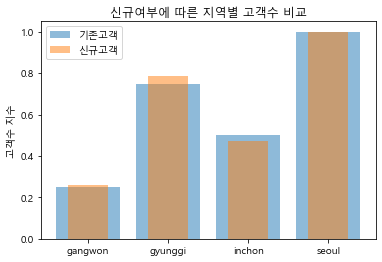

In [54]:
# 신규고객과 기존고객의 지역 분포 비교 시각화

# 신규고객여부별 지역별 고객수 집계
areaComptmp1 = pd.crosstab(custmastTmp1.newCustFlg, custmastTmp1.area).T.reset_index()
display(areaComptmp1)

# 집계된 테이블을 사용해 시각화
# 먼저 기존고객만 챠트 생성
plt.bar(areaComptmp1.area, zrmx_scl(areaComptmp1.N), alpha=0.5, label='기존고객')
# 신규고객 챠트 추가
plt.bar(areaComptmp1.area, zrmx_scl(areaComptmp1.Y), label='신규고객', 
        # 두 막대의 구별이 용이하도록 막대 투명도 조절, 폭 조절
        alpha=0.5, width=0.5)
plt.legend()
plt.title('신규여부에 따른 지역별 고객수 비교')
plt.ylabel('고객수 지수')
plt.show()

In [55]:
# 고객별 주이용점포


custStrTmp1 = sales[['cust_id', 'store']].merge(custSignup[['cust_id', 'newCustFlg']], how='left', on='cust_id')
custStrTmp1['saleFlg'] = 1
custStrTmp1 = custStrTmp1.groupby(['cust_id','store','newCustFlg']).count().reset_index()
custStrTmp1 = custStrTmp1.sort_values('saleFlg')
custStrTmp1

,cust_id,store,newCustFlg,saleFlg
0,B100000003,Multi bupyong,N,1
13713,B100063089,Shoote gasan,N,1
13712,B100063089,Multi bupyong,N,1
13711,B100063089,Esteeme joongang,N,1
13710,B100063083,Shoote gasan,N,1
...,...,...,...,...
4755,B100021660,Multi bupyong,N,8
5111,B100023299,ONL,N,8
14186,B100065222,ONL,N,9
7214,B100032854,ONL,N,9


In [56]:
custStrTmp2 = custStrTmp1.groupby('cust_id').tail(1)
custStrTmp2

,cust_id,store,newCustFlg,saleFlg
13711,B100063089,Esteeme joongang,N,1
13709,B100063083,ONL,N,1
13708,B100063081,Shoote gasan,N,1
13714,B100063091,Shoote gasan,N,1
13707,B100063078,Shoote gasan,N,1
...,...,...,...,...
4755,B100021660,Multi bupyong,N,8
5111,B100023299,ONL,N,8
14186,B100065222,ONL,N,9
7214,B100032854,ONL,N,9


In [57]:
# 신규고객 비율 확인

# 신규고객여부별 인원수 / 전체 인원수 합계
custStrTmp2.newCustFlg.value_counts()/custStrTmp2.newCustFlg.value_counts().sum()

N    0.997366
Y    0.002634
Name: newCustFlg, dtype: float64

In [58]:
newCustStat1_byStore = pd.crosstab(custStrTmp2.newCustFlg, custStrTmp2.store).T.reset_index()
newCustStat1_byStore['rNewCust'] = newCustStat1_byStore.Y / (newCustStat1_byStore.N +newCustStat1_byStore.Y) * 100
newCustStat1_byStore

newCustFlg,store,N,Y,rNewCust
0,Esteeme joongang,531,3,0.561798
1,Multi bupyong,4855,11,0.226058
2,ONL,5832,20,0.341763
3,Shoote city,1507,2,0.132538
4,Shoote gasan,2799,5,0.178317


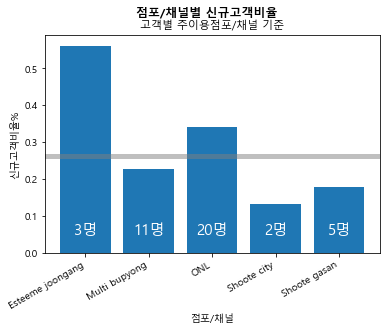

In [59]:
plt.bar(newCustStat1_byStore.store, newCustStat1_byStore.rNewCust)
plt.xlabel('점포/채널')
plt.ylabel('신규고객비율%')
plt.xticks(rotation=30, ha='right')
plt.suptitle('점포/채널별 신규고객비율', weight='bold')
plt.title('고객별 주이용점포/채널 기준', size=11)

# 전체에서의 신규고객비율 산출 (참고용 보조선으로 표시)
newcustRate = float((custStrTmp2.newCustFlg.value_counts()/custStrTmp2.newCustFlg.value_counts().sum()).tail(1).values[0])*100
plt.axhline(newcustRate, color='grey', linewidth=5, alpha=0.5)

# 신규고객수 표시
for i in newCustStat1_byStore.index:
    text2show = str(newCustStat1_byStore.Y[i]) + '명'
    plt.text(i, 0.05, text2show, 
             color='white', size=15, ha='center')

plt.show()

#### 신규고객여부별 구매행동 비교

In [60]:
# 신규고객여부별 구매행동 비교

# 고객별 구매금액과 일수 집계

# 고객별 금액합계 집계 테이블 생성
custSaleamt1 = sales[['cust_id', 'amt']].groupby('cust_id').sum().reset_index()

# 고객별 구매일수 집계 테이블 생성
salesTmp1 = sales[['cust_id', 'date']].copy()
salesTmp1['saleDay'] = salesTmp1.date.str.slice(0,10)
# 고객별 날짜만 추출해 중복제거
salesTmp1 = salesTmp1[['cust_id', 'saleDay']].drop_duplicates().copy()
# 일수 집계
custSaledays1 = salesTmp1[['cust_id', 'saleDay']].groupby('cust_id').count().reset_index()

custSalesTmp1 = custSaleamt1.merge(custSaledays1, how='left', on='cust_id')

custSalesTmp1 = custSalesTmp1.merge(custSignup[['cust_id', 'newCustFlg']], how='left', on='cust_id')
custSalesTmp1

,cust_id,amt,saleDay,newCustFlg
0,B100000003,250000,2,N
1,B100000005,200000,3,N
2,B100000022,35000,1,N
3,B100000023,225000,2,N
4,B100000037,140000,1,N
...,...,...,...,...
15560,B100099964,210000,2,N
15561,B100099970,80000,1,N
15562,B100099976,310000,2,N
15563,B100099981,35000,1,N


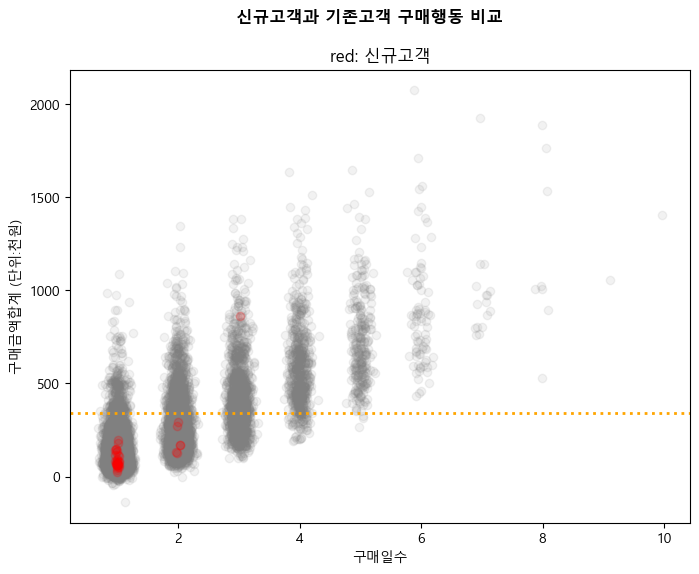

In [61]:
# 고객별 구매일수와 금액합계를 사용한 산점도 작성


plt.figure(figsize=(8,6), dpi=100)

# 기존고객만으로 산점도 생성
plt.scatter(rjitt(custSalesTmp1[custSalesTmp1.newCustFlg=='N'].saleDay), 
            rjitt(custSalesTmp1[custSalesTmp1.newCustFlg=='N'].amt/1000), 
           alpha=0.1, color='grey')

# 신규고객만으로 (red) 산점도 추가
plt.scatter(rjitt(custSalesTmp1[custSalesTmp1.newCustFlg=='Y'].saleDay), 
            # 금액단위를 천원으로 조절
            rjitt(custSalesTmp1[custSalesTmp1.newCustFlg=='Y'].amt/1000), 
           alpha=0.2, color='red')

plt.xlabel('구매일수')
plt.ylabel('구매금액합계 (단위:천원)')
plt.suptitle('신규고객과 기존고객 구매행동 비교', weight='bold')
plt.title('red: 신규고객')

# 금액 상위 20% 지점을 나타내는 보조선 추가
plt.axhline((custSalesTmp1[custSalesTmp1.newCustFlg=='N'].amt/1000).quantile(0.8),
            color='orange', linestyle=':', 
            # 구별이 용이하도록 보조선의 두께 조절
            linewidth=2)
plt.show()

- 신규고객은 자동적으로 최근 3개월 기간, 기존 고객은 총 2년으로 비교하는 것은 문제있음
- 동일하게 최대 3개월로 기간을 일치시켜 비교 필요
- 단, 신규고객은 가입후 3개월 미만인 경우도 있으므로 여전히 완전히 공평한 비교는 아님

In [62]:
# 신규고객여부별 구매행동 비교 - 최근 3개월

# 고객별 구매금액과 일수 집계

# 최근 3개월만으로 고객별 금액합계 집계 테이블 생성
custSaleamt1 = sales[sales.date.str.slice(0,10)>='2020-10-01'][['cust_id', 'amt']].groupby('cust_id').sum().reset_index()

# 고객별 구매일수 집계 테이블 생성
salesTmp1 = sales[['cust_id', 'date']].copy()
salesTmp1['saleDay'] = salesTmp1.date.str.slice(0,10)
# 고객별 날짜만 추출해 중복제거
salesTmp1 = salesTmp1[['cust_id', 'saleDay']].drop_duplicates().copy()
# 일수 집계
custSaledays1 = salesTmp1[['cust_id', 'saleDay']].groupby('cust_id').count().reset_index()

custSalesTmp1 = custSaleamt1.merge(custSaledays1, how='left', on='cust_id')

custSalesTmp1 = custSalesTmp1.merge(custSignup[['cust_id', 'newCustFlg']], how='left', on='cust_id')
custSalesTmp1

,cust_id,amt,saleDay,newCustFlg
0,B100000043,70000,2,N
1,B100000070,130000,3,N
2,B100000079,530000,1,N
3,B100000093,265000,2,N
4,B100000117,70000,2,N
...,...,...,...,...
3811,B100099846,100000,1,N
3812,B100099852,60000,3,N
3813,B100099910,70000,2,N
3814,B100099953,60000,2,N


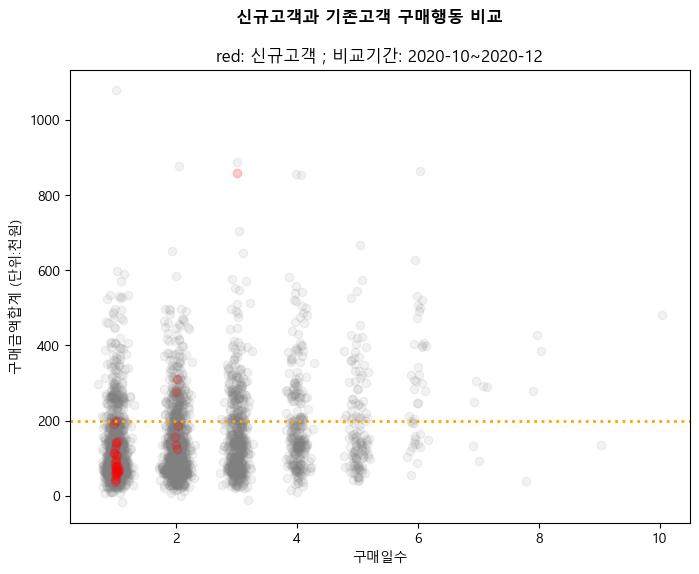

In [63]:
# 고객별 구매일수와 금액합계를 사용한 산점도 작성


plt.figure(figsize=(8,6), dpi=100)

# 기존고객만으로 산점도 생성
plt.scatter(rjitt(custSalesTmp1[custSalesTmp1.newCustFlg=='N'].saleDay), 
            rjitt(custSalesTmp1[custSalesTmp1.newCustFlg=='N'].amt/1000), 
           alpha=0.1, color='grey')

# 신규고객만으로 (red) 산점도 추가
plt.scatter(rjitt(custSalesTmp1[custSalesTmp1.newCustFlg=='Y'].saleDay), 
            # 금액단위를 천원으로 조절
            rjitt(custSalesTmp1[custSalesTmp1.newCustFlg=='Y'].amt/1000), 
           alpha=0.2, color='red')

plt.xlabel('구매일수')
plt.ylabel('구매금액합계 (단위:천원)')
plt.suptitle('신규고객과 기존고객 구매행동 비교', weight='bold')
plt.title('red: 신규고객 ; 비교기간: 2020-10~2020-12')

# 금액 상위 20% 지점을 나타내는 보조선 추가
plt.axhline((custSalesTmp1[custSalesTmp1.newCustFlg=='N'].amt/1000).quantile(0.8),
            color='orange', linestyle=':', 
            # 구별이 용이하도록 보조선의 두께 조절
            linewidth=2)
plt.show()